# **Digital Signal and Image Management - Assignment 5**<br/>
**Master's Degree in Data Science (A.Y. 2021/2022)**<br/>
**University of Milano - Bicocca**<br/>

Nabil  EL Asri


Implement a classification script based on the fine tuning of a neural network, following the guidelines shown during the laboratory.

Rules:

1. Use the same 101-object dataset
2. Use a different architecture (i.e. no mobile net) --> **ResNet50**
3. Experiment with Data augmentation operations

In [ ]:
#----- set tf version and install packages
!pip install tensorflow==2.1
!pip install -q keras==2.3.0

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from keras.applications.resnet50 import ResNet50

from keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop, Nadam, SGD
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import tarfile
from time import time
from shutil import copyfile

Using TensorFlow backend.


# 1. File management

In [ ]:
t0 = time()
# Link Google Drive account, transfer dataset, and extract files
copyfile('gdrive/My Drive/101_ObjectCategories_split.tar', '101_ObjectCategories_split.tar')
tar = tarfile.open('101_ObjectCategories_split.tar')
tar.extractall()
tar.close()
print("File transfer completed in %0.3f seconds" % (time() - t0))

File transfer completed in 5.264 seconds


In [ ]:
# base_path indicates the directory where the training and test set files are located
# root indicates the directory in which I will save the information that I will extract subsequently
base_path = '101_ObjectCategories_split/'
root = "gdrive/My Drive/"

# 2. Data loader & Preprocessing

In this phase we will process the images on the basis of the pre-trained network (in our case Resnet50 with IMAGENET weights) both for the training and for the test set. Moreover for the training set we will apply data augmentation operations (rotation, shift, zoom etc) thanks to the ImageDataGenerator function. 

In [ ]:
# train processing
train_processing = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50,
                                      rotation_range = 25,
                                      width_shift_range = .2,
                                      height_shift_range = .2,
                                      horizontal_flip = True,
                                      zoom_range = .2)

train_generator = train_processing.flow_from_directory('101_ObjectCategories_split/train/',
                        target_size = (224, 224),
                        color_mode = 'rgb',
                        class_mode = 'categorical',
                        batch_size = 32,
                        shuffle = True,
                        seed = 1)

Found 4600 images belonging to 102 classes.


In [ ]:
# test processing
test_processing = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)
test_generator = test_processing.flow_from_directory('101_ObjectCategories_split/test/',
                        target_size = (224, 224),
                        color_mode = 'rgb',
                        class_mode = 'categorical',
                        batch_size = 32,
                        shuffle = True,
                        seed = 1)

Found 4544 images belonging to 102 classes.


# 3. Feature extraction from pre-trained network

At this point it has been decided to carry out the assigned task practicing a feature extraction from the last available layer of the pre-trained network in such a way to save time avoiding to train the network every time and therefore to make the features available without having to import the 101-object dataset. 

In [ ]:
# I define the function that will be used
def extract_features(data, augmentation = False, iterations = 5):

# data: train_generator or test_generator
# augmentation: true or false depending on whether you want to apply data augmentation
# iterations: how many iterations of data augmentation you want to do
  
# Base model (ResNet50)
  base_model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (224, 224, 3),
                   pooling='avg')

# Freezing the base model (only for finetuning a pretrained model)  
  for layer in base_model.layers:
    layer.trainable = False

  
  dims = []
  for dim in base_model.output_shape:
    if dim == None:
      pass
    else:
      dims.append(dim)
  reshaping = np.prod(np.array(dims))
  
  if augmentation:
    
    features = []
    labels = []
    for i in range(iterations):
      data.reset()

      lab = []
      for index in range(len(data)):
        lab.append(data[index][1])
      lab =  np.vstack(lab)

      feat = base_model.predict_generator(data, verbose = 1)
      features.append(feat)
      labels.append(lab)

    features = np.vstack(features)
    labels = np.vstack(labels)

  else:
      
    labels = []
    for index in range(len(data)):
      labels.append(data[index][1])

    labels = np.vstack(labels)
    features = base_model.predict_generator(data, verbose = 1)
    features = features.reshape((features.shape[0], reshaping))
  
  print("\nDims features {}\nDims labels {}".format(features.shape, labels.shape))

  del dims, reshaping, base_model

  return features, labels

In [ ]:
# apply the function and save the information
# ReseNet50 without data augmentation on the training set
train_features, train_labels = extract_features(train_generator)
np.savez(os.path.join(root, "resnet50.npz"), features = train_features, labels = train_labels)

# save the labels that will be used in the classification report
np.save(root+"/labels.npy", train_generator.class_indices, allow_pickle = True)

print("ResNet50 on the training set has been saved")

144/144 [==============================] - 76s 531ms/step

Dims features (4600, 2048)
Dims labels (4600, 102)
ResNet50 on the training set has been saved


In [ ]:
# ResNet50 on the test set
test_features, test_labels = extract_features(test_generator)
np.savez(os.path.join(root, "resnet50_test.npz"), features = test_features, labels = test_labels)

print("ResNet50 on the test set has been saved")

142/142 [==============================] - 52s 363ms/step

Dims features (4544, 2048)
Dims labels (4544, 102)
ResNet50 on the test set has been saved


In [ ]:
# ResNet50 with data augmentat on the training set
train_features, train_labels = extract_features(train_generator, augmentation=True, iterations = 10)
np.savez(os.path.join(root, "resnet50_aug.npz"), features = train_features, labels = train_labels)

print("ResNet50 with data augmentation on the training set has been saved")

144/144 [==============================] - 73s 504ms/step

Dims features (46000, 2048)
Dims labels (46000, 102)
ResNet50 with data augmentation on the training set has been saved


# 4. ResNet50

I define a function to easily import features extracted from the training and test set to use as data to train additional layers for the fine tuning task. In this section we will proceed considering the images without data augmentation; we will apply this last technique in the next section in order to make a comparison in terms of performance. 

In [ ]:
def info_import(model_train, model_test):
  with np.load(os.path.join(root, model_train)) as data:
    x_train = data['features']
    y_train = data['labels']
    
  with np.load(os.path.join(root, model_test)) as data:
    x_test = data['features']
    y_test = data['labels']
  
  labels = np.load(root+"/labels.npy", allow_pickle = True)
  print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
  return x_train, x_test, y_train, y_test, labels

In [ ]:
# data import
x_train, x_test, y_train, y_test, labels = info_import("resnet50.npz","resnet50_test.npz")

(4600, 2048) (4544, 2048) (4600, 102) (4544, 102)


Model specialization: 
- 2 Fully connected layers with 512 and 128 neurons respectively and with ReLU non-linearity as the activation function;
- 3 dropouts for the purpose of regularization;
- final fully connected layer mapping to the problem size (102 classes) with softmax activation function.

Note how any subsequent training will only work on levels added later as learned in class. Also no preprocessing operation has been done since it was already done at the beginning of the notebook.


In [ ]:
# Explicit input layer
inputs = Input(shape = (x_train.shape[1],))
drop = Dropout(.3)(inputs)
# New intermediate fully-connected layer + ReLU + dropout
x = Dense(512, activation = 'relu')(drop)
drop = Dropout(.4)(x)
# New intermediate fully-connected layer + ReLU + dropout
x = Dense(128, activation='relu')(drop)
drop = Dropout(.3)(x)
# New (final) fully-connected layer + SoftMax activation
outputs = Dense(y_train.shape[1],activation = 'softmax')(drop)

We ''encapsulated'' everything into a new model, which we named ``net``, having the following interface:
* input: a 224$\times$224 placeholder
* output: the output of the model extension (based on Dense layers) which we just defined

In [ ]:
net = Model(inputs = inputs, outputs = outputs)

# Print some high-level summaries
net.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 102)               1315

In [ ]:
# Compile the model for training
net.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=.0001), metrics=['accuracy'])

In [ ]:
# Model training
epochs = 50
batch_size = 128
network_history = net.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test))

Train on 4600 samples, validate on 4544 samples
Epoch 1/50
4600/4600 [==============================] - 1s 135us/step - loss: 4.6340 - accuracy: 0.0785 - val_loss: 3.9014 - val_accuracy: 0.2584
Epoch 2/50
4600/4600 [==============================] - 0s 90us/step - loss: 3.9447 - accuracy: 0.2102 - val_loss: 3.2776 - val_accuracy: 0.3145
Epoch 3/50
4600/4600 [==============================] - 0s 92us/step - loss: 3.4769 - accuracy: 0.2824 - val_loss: 2.8961 - val_accuracy: 0.3999
Epoch 4/50
4600/4600 [==============================] - 0s 86us/step - loss: 3.1833 - accuracy: 0.3211 - val_loss: 2.6323 - val_accuracy: 0.4630
Epoch 5/50
4600/4600 [==============================] - 0s 88us/step - loss: 2.9502 - accuracy: 0.3604 - val_loss: 2.4083 - val_accuracy: 0.5299
Epoch 6/50
4600/4600 [==============================] - 0s 93us/step - loss: 2.7571 - accuracy: 0.3863 - val_loss: 2.1685 - val_accuracy: 0.5772
Epoch 7/50
4600/4600 [==============================] - 0s 87us/step - loss: 2.56

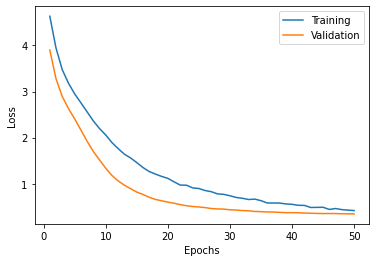

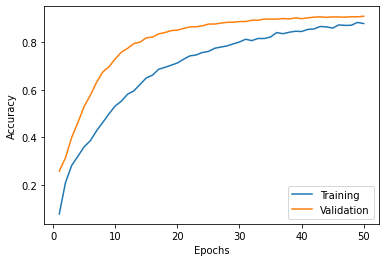

In [ ]:
# plotting
x_plot = list(range(1,epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

The model seems to behave quite well; the training curve converges more slowly than the validation curve, which proves the use of a pre-trained model with imagenet.

In [ ]:
# classification report
y_pred = net.predict(x_test)
y_pred = np.argmax(y_pred, axis = -1)

print(classification_report(np.argmax(y_test, axis = -1),
                            y_pred,
                            target_names = labels.all().keys()))

y_pred = net.predict(x_test)

                   precision    recall  f1-score   support

BACKGROUND_Google       0.79      0.79      0.79       234
            Faces       0.98      0.98      0.98       217
       Faces_easy       1.00      0.97      0.98       217
         Leopards       0.93      0.98      0.96       100
       Motorbikes       0.99      1.00      0.99       399
        accordion       0.96      0.96      0.96        27
        airplanes       0.98      1.00      0.99       400
           anchor       1.00      0.38      0.55        21
              ant       0.73      0.52      0.61        21
           barrel       1.00      0.87      0.93        23
             bass       0.90      0.67      0.77        27
           beaver       0.94      0.70      0.80        23
        binocular       0.89      1.00      0.94        16
           bonsai       0.94      0.94      0.94        64
            brain       0.82      0.96      0.89        49
     brontosaurus       0.76      0.62      0.68       

Performance is satisfactory (90% accuracy) although it should be noted that the test set was also used as validation.

# ResNet50 with data augmentation

I proceed in the exact same way I did until now but adding the application of data augmentation to the images of the training set.

In [ ]:
# data import
x_train, x_test, y_train, y_test, labels = info_import("resnet50_aug.npz","resnet50_test.npz")

(46000, 2048) (4544, 2048) (46000, 102) (4544, 102)


Model specialization (like before): 
- 2 Fully connected layers with 512 and 128 neurons respectively and with ReLU non-linearity as the activation function;
- 3 dropouts for the purpose of regularization;
- final fully connected layer mapping to the problem size (102 classes) with softmax activation function.

In [ ]:
# Explicit input layer
inputs = Input(shape = (x_train.shape[1],))
drop = Dropout(.3)(inputs)
# New intermediate fully-connected layer + ReLU + dropout
x = Dense(512, activation = 'relu')(drop)
drop = Dropout(.4)(x)
# New intermediate fully-connected layer + ReLU + dropout
x = Dense(128, activation='relu')(drop)
drop = Dropout(.3)(x)
# New (final) fully-connected layer + SoftMax activation
outputs = Dense(y_train.shape[1],activation = 'softmax')(drop)

In [ ]:
net = Model(inputs = inputs, outputs = outputs)

# Print some high-level summaries
net.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 102)               1315

In [ ]:
# Compile the model for training
net.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=.0001), metrics=['accuracy'])

In [ ]:
# Model training
epochs = 50
batch_size = 128
network_history = net.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test))

Train on 46000 samples, validate on 4544 samples
Epoch 1/50
46000/46000 [==============================] - 3s 68us/step - loss: 3.0437 - accuracy: 0.3497 - val_loss: 1.3455 - val_accuracy: 0.7214
Epoch 2/50
46000/46000 [==============================] - 3s 62us/step - loss: 1.5218 - accuracy: 0.6290 - val_loss: 0.6392 - val_accuracy: 0.8528
Epoch 3/50
46000/46000 [==============================] - 3s 61us/step - loss: 0.9800 - accuracy: 0.7410 - val_loss: 0.4482 - val_accuracy: 0.8882
Epoch 4/50
46000/46000 [==============================] - 3s 61us/step - loss: 0.7435 - accuracy: 0.7982 - val_loss: 0.3774 - val_accuracy: 0.9025
Epoch 5/50
46000/46000 [==============================] - 3s 61us/step - loss: 0.6028 - accuracy: 0.8307 - val_loss: 0.3374 - val_accuracy: 0.9135
Epoch 6/50
46000/46000 [==============================] - 3s 62us/step - loss: 0.5107 - accuracy: 0.8541 - val_loss: 0.3165 - val_accuracy: 0.9144
Epoch 7/50
46000/46000 [==============================] - 3s 61us/ste

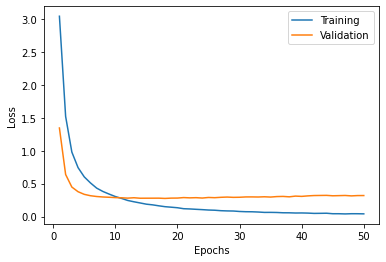

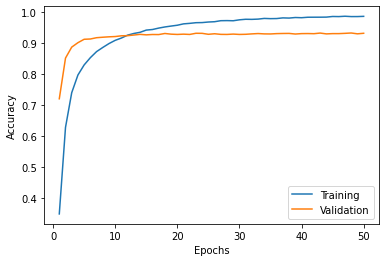

In [ ]:
# plotting
x_plot = list(range(1,epochs+1))
plot_history(network_history)

In [ ]:
# classification report
y_pred = net.predict(x_test)
y_pred = np.argmax(y_pred, axis = -1)

print(classification_report(np.argmax(y_test, axis = -1),
                            y_pred,
                            target_names = labels.all().keys()))

y_pred = net.predict(x_test)

                   precision    recall  f1-score   support

BACKGROUND_Google       0.85      0.77      0.81       234
            Faces       0.98      0.98      0.98       217
       Faces_easy       1.00      0.97      0.99       217
         Leopards       1.00      1.00      1.00       100
       Motorbikes       1.00      1.00      1.00       399
        accordion       1.00      1.00      1.00        27
        airplanes       0.99      1.00      1.00       400
           anchor       1.00      0.57      0.73        21
              ant       0.73      0.52      0.61        21
           barrel       0.96      0.96      0.96        23
             bass       0.81      0.78      0.79        27
           beaver       0.87      0.87      0.87        23
        binocular       0.89      1.00      0.94        16
           bonsai       0.97      0.98      0.98        64
            brain       0.90      0.96      0.93        49
     brontosaurus       0.84      0.76      0.80       

The application of data augmentation, variations on image tilt, height and width shifts, horizontal tilting and zooming, in the case of this particular dataset, does not seem to have affected the final performance much; paradoxically the model with data augmentation performs slightly better than the one without data augmentation. 